In [120]:
#importing libraries

import os
import cv2
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
keras = tf.keras
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import rotate

In [2]:
#reading the dataset
dataset_dir = "./dataset"

print(os.listdir(dataset_dir))
train_classes = os.listdir(dataset_dir + "/train")
print(train_classes)
test_classes = os.listdir(dataset_dir + "/test")
print(test_classes)

['test', 'train']
['Closed', 'no_yawn', 'Open', 'yawn']
['Closed', 'no_yawn', 'Open', 'yawn']


In [95]:
#loading the dataset
#{'Closed': 0, 'no_yawn': 2, 'Open': 1, 'yawn': 3}
dataset_dir = "./dataset"

def load_images(directory, returnYawn = False):
    images = []
    labels = []
    open_eyes = []
    closed_eyes = []
    yawn = []
    no_yawn = []
    active_subject = []
    fatigue_subject = []

    for category in os.listdir(directory):
        print(category)
        for filename in tqdm(os.listdir(directory+category)):
            image_path = os.path.join(directory,category,filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
            image = cv2.resize(image,(224,224))
            image = image.astype('float32') / 255.0  # Scale pixel values to [0, 1]
            images.append(image)
            if(category == 'Open' or category == 'Open_Eyes'):
                numb = 1
                #open_eyes.append(image)
            elif(category ==  'no_yawn'):
                numb = 2 
                no_yawn.append(image)
            elif(category == 'yawn'):
                numb = 3
                yawn.append(image)
            elif(category == 'Active Subjects'):
                numb = 4
                #active_subject.append(image)
            elif(category == 'Fatigue Subjects'):
                numb = 5
                #fatigue_subject.append(image)
            else :
                numb = 0
                #closed_eyes.append(image)
            labels.append(numb)

    images = np.array(images,dtype='float32')
    if(not returnYawn):
        return images, np.array(labels)
    return images, np.array(labels), yawn, no_yawn
    #return open_eyes, closed_eyes, yawn, no_yawn, active_subject, fatigue_subject

label_classes = ['closed', 'open', 'no_yawn', 'yawn', 'active', 'fatigued']
#loading dataset
print('*******Loading Train Data*******')
#open_eyes, closed_eyes, yawn, no_yawn, active_subject, fatigue_subject = load_images(dataset_dir + '/train/' )
train_ds = load_images(dataset_dir + '/train/' )


*******Loading Train Data*******
Active Subjects


  0%|          | 0/2558 [00:00<?, ?it/s]

Closed


  0%|          | 0/726 [00:00<?, ?it/s]

Fatigue Subjects


  0%|          | 0/2558 [00:00<?, ?it/s]

no_yawn


  0%|          | 0/725 [00:00<?, ?it/s]

Open


  0%|          | 0/726 [00:00<?, ?it/s]

yawn


  0%|          | 0/723 [00:00<?, ?it/s]

'print(len(open_eyes))\nprint(len(closed_eyes))\nprint(len(active_subject))\nprint(len(fatigue_subject))\nprint(len(yawn))\nprint(len(no_yawn))'

In [78]:
#displaying images function
def display_images_with_labels(images, labels, prediction):
    
    fig, axs = plt.subplots(5, 8, figsize=(15, 10))
    fig.suptitle('Images and Labels')
    for i in range(40):
        axs[i // 8, i % 8].imshow(images[i])
        axs[i // 8, i % 8].axis('off')
        if(prediction):
            axs[i // 8, i % 8].set_title(label_classes[np.argmax(labels[i])])
        else:
            axs[i // 8, i % 8].set_title(label_classes[labels[i]])
    plt.show()

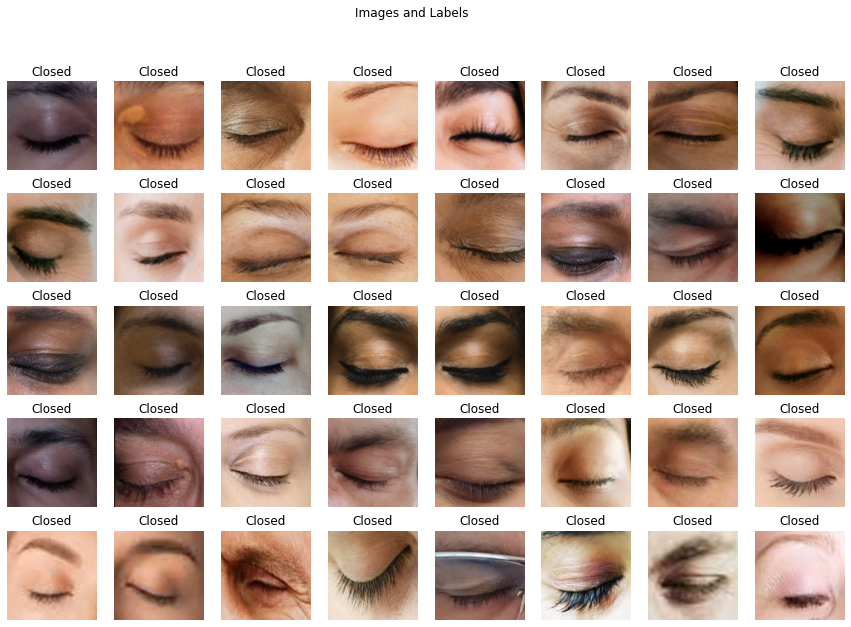

In [56]:
#showing the dataset

display_images_with_labels(train_ds[0], train_ds[1], False)

In [96]:
def display_random_images_with_labels(images, labels):
    """
        Display 40 random images and their labels from the input arrays.
    """
    # Choose 40 random images
    indices = random.sample(range(len(images)), 40)
    random_images = [images[i] for i in indices]
    random_labels = [labels[i] for i in indices]
    
    fig, axs = plt.subplots(5, 8, figsize=(15, 10))
    fig.suptitle('Random Images and Labels')
    for i, (image, label) in enumerate(zip(random_images, random_labels)):
        axs[i // 8, i % 8].imshow(image)
        axs[i // 8, i % 8].axis('off')
        axs[i // 8, i % 8].set_title(label_classes[label])
    plt.show()

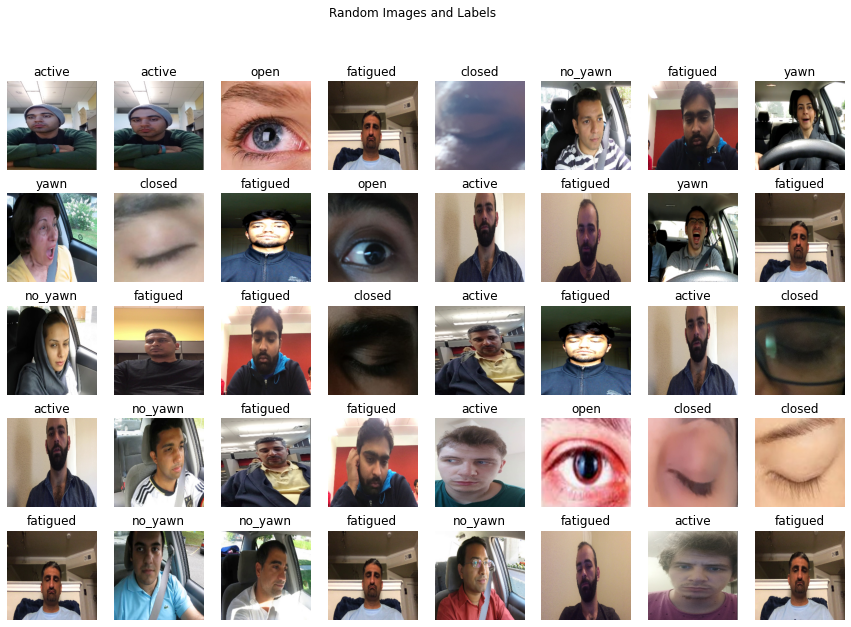

In [98]:
display_random_images_with_labels(train_ds[0], train_ds[1])

4809
1603
1604


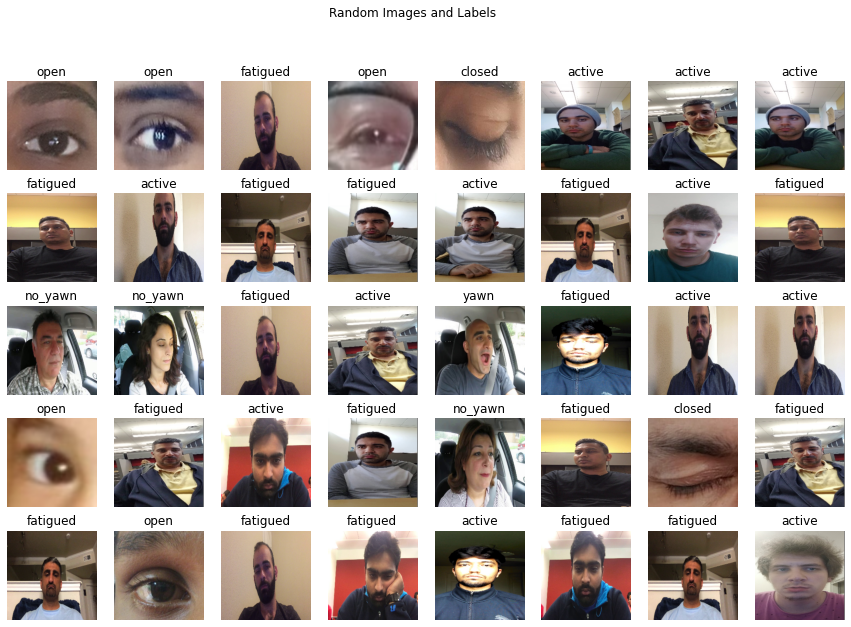

In [99]:
#spliting dataset
x_train,y_train = train_ds
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
print(len(x_train))
print(len(x_test))
print(len(x_val))
display_random_images_with_labels(x_train, y_train)

In [103]:
# izdelava modela 

# Define a sequential model
model = models.Sequential()
# Add a 2D convolutional layer with 16 filters, a 3x3 kernel size, ReLU activation, and input shape of (224, 224, 3)
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Add a max pooling layer with a 2x2 pool size
model.add(layers.MaxPooling2D((2, 2)))
# Add another 2D convolutional layer with 32 filters and a 3x3 kernel size
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# Add another max pooling layer
model.add(layers.MaxPooling2D((2, 2)))
# Add a third 2D convolutional layer with 64 filters and a 3x3 kernel size
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Flatten the output from the convolutional layers into a 1D array
model.add(layers.Flatten())
# Add a dense layer with 128 units and ReLU activation
model.add(layers.Dense(128, activation='relu'))
# Add a dense output layer with 4 units and no activation function (for multi-class classification)
model.add(layers.Dense(6, activation=None))

In [104]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))#print(y_test[0])
print(x_train.shape)
print(y_train.shape)
# izvedba ucenja 

history = model.fit(x_train, y_train, epochs=8,
                    validation_data=(x_test, y_test))

4809
4809
1603
1603
(4809, 224, 224, 3)
(4809,)
Epoch 1/8
151/151 [==============================] - 101s 663ms/step - loss: 0.6478 - accuracy: 0.7767 - val_loss: 0.3107 - val_accuracy: 0.8665
Epoch 2/8
151/151 [==============================] - 94s 620ms/step - loss: 0.2808 - accuracy: 0.8756 - val_loss: 0.2661 - val_accuracy: 0.8915
Epoch 3/8
151/151 [==============================] - 93s 614ms/step - loss: 0.2330 - accuracy: 0.9062 - val_loss: 0.2562 - val_accuracy: 0.8971
Epoch 4/8
151/151 [==============================] - 95s 631ms/step - loss: 0.2326 - accuracy: 0.9043 - val_loss: 0.2348 - val_accuracy: 0.9027
Epoch 5/8
151/151 [==============================] - 96s 639ms/step - loss: 0.1676 - accuracy: 0.9351 - val_loss: 0.2528 - val_accuracy: 0.8977
Epoch 6/8
151/151 [==============================] - 98s 648ms/step - loss: 0.1491 - accuracy: 0.9401 - val_loss: 0.2717 - val_accuracy: 0.9002
Epoch 7/8
151/151 [==============================] - 97s 640ms/step - loss: 0.1326 - ac

In [106]:
def chart(history):

    plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

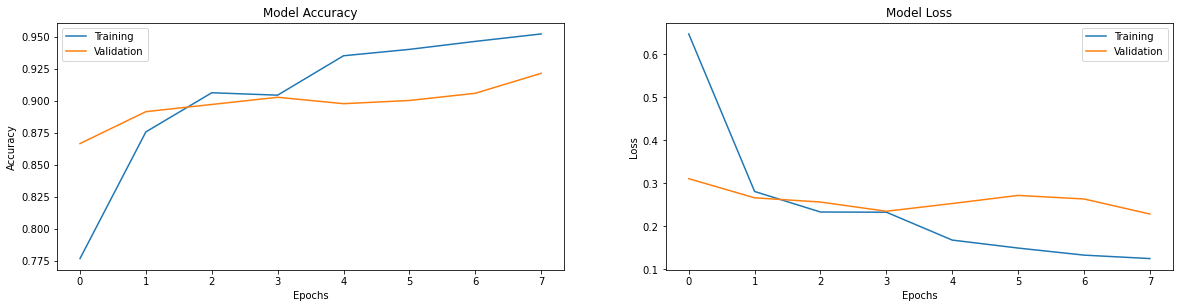

In [107]:
chart(history)

In [115]:
def calculate_accuracy(prediction, y_val, label_number = -1):
    """
    Calculates the accuracy of the prediction given the correct labels.

    Args:
    prediction (list): List of predicted labels.
    y_val (list): List of correct labels.

    Returns:
    float: Accuracy of the prediction as a percentage.
    """

    # Get the total number of examples in the dataset
    num_examples = len(prediction)
    num_correct = 0
    if(label_number == -1):
        # Calculate the number of correctly predicted labels
        num_correct = sum([1 if np.argmax(prediction[i]) == y_val[i] else 0 for i in range(num_examples)])
    else:
        num_examples = 0
        for i in range(len(y_val)):
            if y_val[i] == label_number :
                num_examples += 1
                if(y_val[i] ==  np.argmax(prediction[i])):
                    num_correct += 1


    # Calculate the accuracy as a percentage
    accuracy = (num_correct / num_examples) * 100

    return accuracy


In [117]:
predictions = model.predict(x_val) 

51/51 [==============================] - 5s 99ms/step


whole Accuracy: 91.71%
closed Accuracy: 97.28%
open Accuracy: 95.92%
yawn Accuracy: 92.07%
no_yawn Accuracy: 90.44%
active Accuracy: 95.59%
fatigue Accuracy: 84.87%


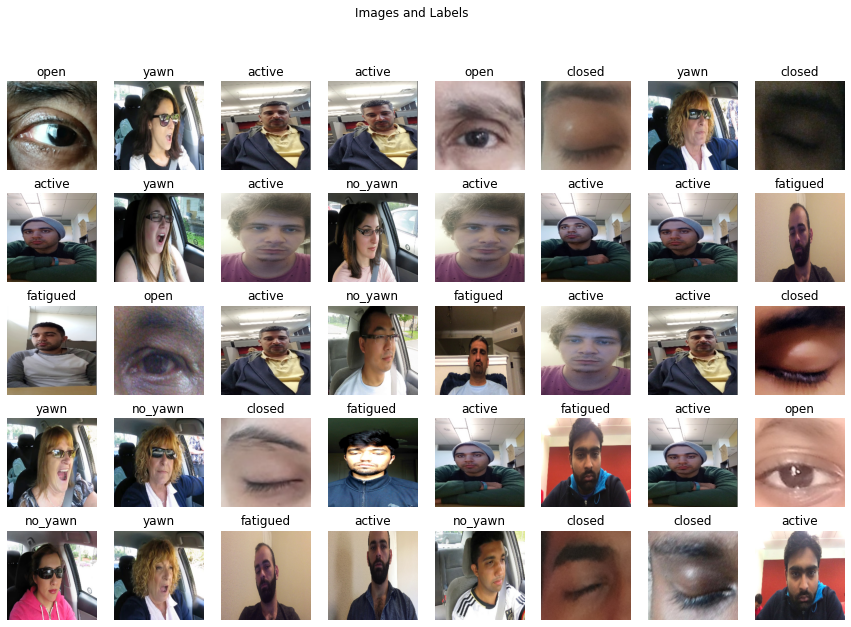

In [118]:
#model prediction label_classes = ['closed', 'open', 'no_yawn', 'yawn', 'active', 'fatigued']

accuracy = calculate_accuracy(predictions, y_val)
print("whole Accuracy: {:.2f}%".format(accuracy))

closed_accuracy = calculate_accuracy(predictions, y_val, label_number = 0)
print("closed Accuracy: {:.2f}%".format(closed_accuracy))
open_accuracy = calculate_accuracy(predictions, y_val, label_number = 1)
print("open Accuracy: {:.2f}%".format(open_accuracy))
yawn_accuracy = calculate_accuracy(predictions, y_val,label_number = 3)
print("yawn Accuracy: {:.2f}%".format(yawn_accuracy))
no_yawn_accuracy = calculate_accuracy(predictions,y_val,label_number = 2)
print("no_yawn Accuracy: {:.2f}%".format(no_yawn_accuracy))
active_accuracy = calculate_accuracy(predictions, y_val, label_number = 4)
print("active Accuracy: {:.2f}%".format(active_accuracy))
fatigue_accuracy = calculate_accuracy(predictions,y_val,label_number = 5)
print("fatigue Accuracy: {:.2f}%".format(fatigue_accuracy))
display_images_with_labels(x_val, predictions, True)




# Increasing the datasets
i want to see if the accuracy improves with a larger dataset size.
In the training before i use smaller datatsets for active subject (2558 images) and fatigued subjects(2558 images), so i will now use a larger dataset with 4560 images. 
Also to increase the number of images in the dataset for closed and open eyes i will use another dataset, so together there will be 2726 images for closed eyes and 2726 images for open eyes.
For yawning and no yawning dataset i do not seem to find another dataset. So i will simulate with transforming existing images.

In [ ]:
label_classes = ['closed', 'open', 'no_yawn', 'yawn', 'active', 'fatigued']
#loading dataset
print('*******Loading Train Data*******')
#open_eyes, closed_eyes, yawn, no_yawn, active_subject, fatigue_subject = load_images(dataset_dir + '/train/' )
x_train, y_train, yawn_images, no_yawn_images = load_images('datasetBig/train/', True )
display_images_with_labels(x_train, y_train, False)




In [119]:
# augmentation
def rotate1(faces, labels):
    facesTmp =np.array( faces.copy())
    rotatedFaces = np.array([])
    rotatedLabels = np.array([])
    for j in range(10):
        for i in range(len(faces)):
            facesTmp[i] = rotate(faces[i], 30 * j, reshape=False)
        #show_40_distinct_people(facesTmp, np.unique(labels))
        if rotatedFaces.size == 0:
            rotatedFaces = facesTmp
            rotatedLabels = labels
        else:
            rotatedFaces = np.concatenate((rotatedFaces, facesTmp))
            rotatedLabels = np.concatenate((rotatedLabels, labels))
    return rotatedFaces, rotatedLabels

In [ ]:
yawn_images_labels = np.fill()